# Multivariate regression to predict the wind speed field

In [2]:
import torch
import torch.nn as nn
import numpy as np
import random

from utils.data_loaders import get_wake_dataloaders
import utils.utils as utils
import utils.data_utils as data_utils 
from utils.metrics import MetricsLogger
import utils.plotting as plotting
from utils.evaluation import test_pytorch_model

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [3]:
HIDDEN_LAYERS_UNITS = [50, 500]
ACTIVATION_FUNCTION = nn.ReLU()

class MultivariateNN(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(MultivariateNN, self).__init__()
        layer_units = [input_space] + HIDDEN_LAYERS_UNITS
        layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            layers += [nn.Linear(first, second), ACTIVATION_FUNCTION]
        layers.append(nn.Linear(layer_units[-1], output_space)) # last layer not activated
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

#TODO add regularization term in the loss function?

In [4]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {'ti': 4, 'ct': 4}
train_reduc_factor_string = "training_factors=" + "-".join([f"{k}{v}" for k, v in INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR.items()])
MODEL_NAME = f"multivariate_NN_layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}_{train_reduc_factor_string}"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
CONSIDER_WS = False
COORDS_AS_INPUT = False # multivariate setting
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"\
        .replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
print(f"Model name: {MODEL_NAME}")
print(f"Best model path: {BEST_MODEL_PATH}")

# hyperparameters
BATCH_SIZE = 64
EPOCHS = 125
LR = 0.001

MODEL_DESCRIPTION = f"{MODEL_NAME}_{FACTORS_FOLDER}: act. func. {ACTIVATION_FUNCTION.__class__.__name__} " +\
    f"(not last layer), batch size {BATCH_SIZE}, {EPOCHS} epochs, lr={LR})"
print(f"Model description: {MODEL_DESCRIPTION}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {DEVICE}")

Model name: multivariate_NN_layers50-500_training_factors=ti4-ct4_consider_ws
Best model path: saved_models/discr_factors_x2_30_y-2_2_step0.125_reducedTI-CT/multivariate_NN_layers50-500_training_factors=ti4-ct4_consider_ws.pt
Model description: multivariate_NN_layers50-500_training_factors=ti4-ct4_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 125 epochs, lr=0.001)

Device: cpu


In [8]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATA_FOLDER,
                                                          consider_ws=CONSIDER_WS,
                                                          coords_as_input=COORDS_AS_INPUT,
                                                          #train_perc=0.6,
                                                          #test_perc=0.2,
                                                          #validation_perc=0.2,
                                                          input_var_to_train_reduction_factor=INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR,
                                                          batch_size=BATCH_SIZE)
len(train_dataloader)

ValueError: input_var_to_train_reduction_factor should be specified only when not considering ws

In [ ]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

input_space = train_dataloader.dataset.inputs.shape[1]
output_space = train_dataloader.dataset.outputs.shape[1]
print(f"{input_space=}\t{output_space=}")

torch.Size([64, 3]) torch.Size([64, 7168])
input_space=3	output_space=7168


Logging multivariate_NN_layers50-500_consider_ws
Epoch 0 ->	Training loss (MSE)=0.0003583272251196445	Validation loss (MSE)=3.919666266566227e-05	
Epoch 1 ->	Training loss (MSE)=2.3899684902227654e-05	Validation loss (MSE)=1.4242542456486262e-05	
Epoch 2 ->	Training loss (MSE)=1.0045363995287158e-05	Validation loss (MSE)=7.943058699311223e-06	
Epoch 3 ->	Training loss (MSE)=6.153236084201401e-06	Validation loss (MSE)=5.34098188257882e-06	
Epoch 4 ->	Training loss (MSE)=4.366758923424641e-06	Validation loss (MSE)=3.551312575754392e-06	
Epoch 5 ->	Training loss (MSE)=3.130369671425521e-06	Validation loss (MSE)=2.704120310723242e-06	
Epoch 6 ->	Training loss (MSE)=2.274119025087478e-06	Validation loss (MSE)=2.5916480849859496e-06	
Epoch 7 ->	Training loss (MSE)=1.8960882099980319e-06	Validation loss (MSE)=1.932126396737162e-06	
Epoch 8 ->	Training loss (MSE)=1.5840043843954018e-06	Validation loss (MSE)=1.5441077994182706e-06	
Epoch 9 ->	Training loss (MSE)=1.3988340662597858e-06	Validatio

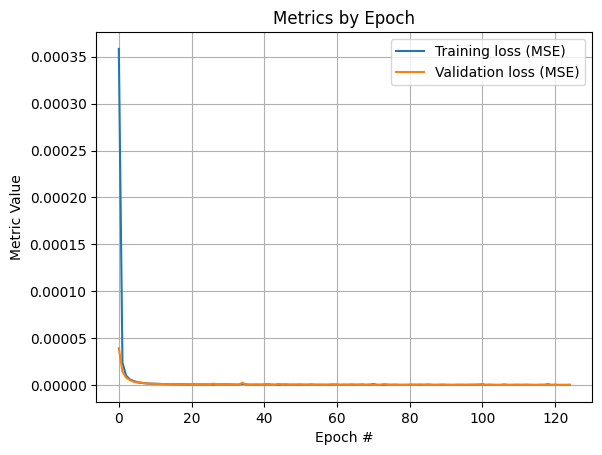

Metrics exported in the following csv file: logged_metrics/multivariate_NN_layers50-500_consider_ws_06-06-2023_11-57-35.csv


In [ ]:
model = MultivariateNN(input_space, output_space).to(DEVICE)

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=LR
)

loss_function = torch.nn.MSELoss()
#rmse_function = RMSELoss()

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_v_loss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    model.train(True)
    epoch_t_loss = 0
    epoch_t_rmse = 0
    for batch in iter(train_dataloader):
        input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()
        prediction = model.forward(input_features)
        tloss = loss_function(prediction, wake_field)
        tloss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_t_loss += tloss.item() * input_features.size(0)

        # other metrics
        #rmse = rmse_function(prediction, wake_field)
        #epoch_t_rmse += rmse.item() * input_features.size(0)

    avg_t_loss = epoch_t_loss / len(train_dataloader.sampler)
    #avg_t_rmse = epoch_t_rmse / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss (MSE)', avg_t_loss)
    #metrics_logger.log_metric(epoch, 'Training RMSE', avg_t_rmse)

    '''VALIDATION'''
    if valid_dataloader:
        model.train(False)
        epoch_v_loss = 0
        epoch_v_rmse = 0
        for batch in iter(valid_dataloader):
            input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)
            prediction = model(input_features)
            
            vloss = loss_function(prediction, wake_field)
            epoch_v_loss += vloss.item() * input_features.size(0)
            #rmse = rmse_function(prediction, wake_field)
            #epoch_v_rmse += rmse.item() * input_features.size(0)

        avg_v_loss = epoch_v_loss / len(valid_dataloader.sampler)
        #avg_v_rmse = epoch_v_rmse / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss (MSE)', avg_v_loss)
        #metrics_logger.log_metric(epoch, 'Validation RMSE', avg_v_rmse)
        # Track best performance, and save the model's state
        if avg_v_loss < best_v_loss:
            best_vloss = avg_v_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)

metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

# Testing

In [ ]:
# loading best model
model = MultivariateNN(input_space, output_space).to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
test_pytorch_model(model, test_dataloader,
                   model_description=MODEL_DESCRIPTION,
                   save_results=True)

Test results for multivariate_NN_layers50-500_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 125 epochs, lr=0.001)
r2_score=0.996487304535175
explained_variance_score=0.9986422058261398
mean_squared_error=2.323798611314487e-07
mean_absolute_error=0.0003187025140505284
median_absolute_error=0.0002758386544883251
mean_absolute_percentage_error=27633840128.0


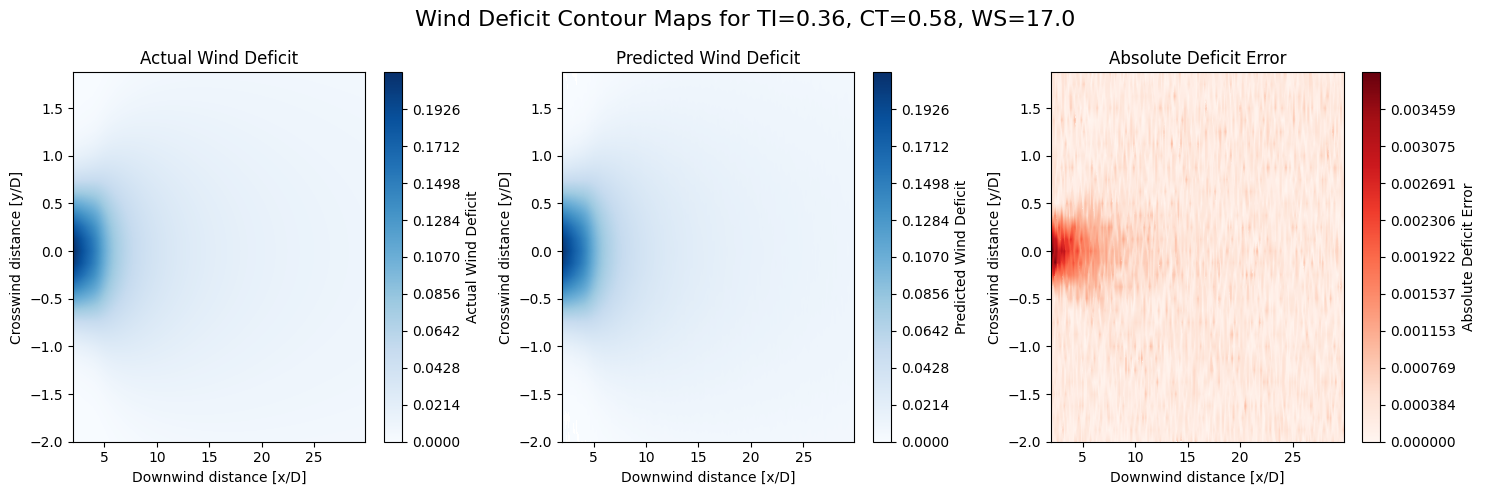

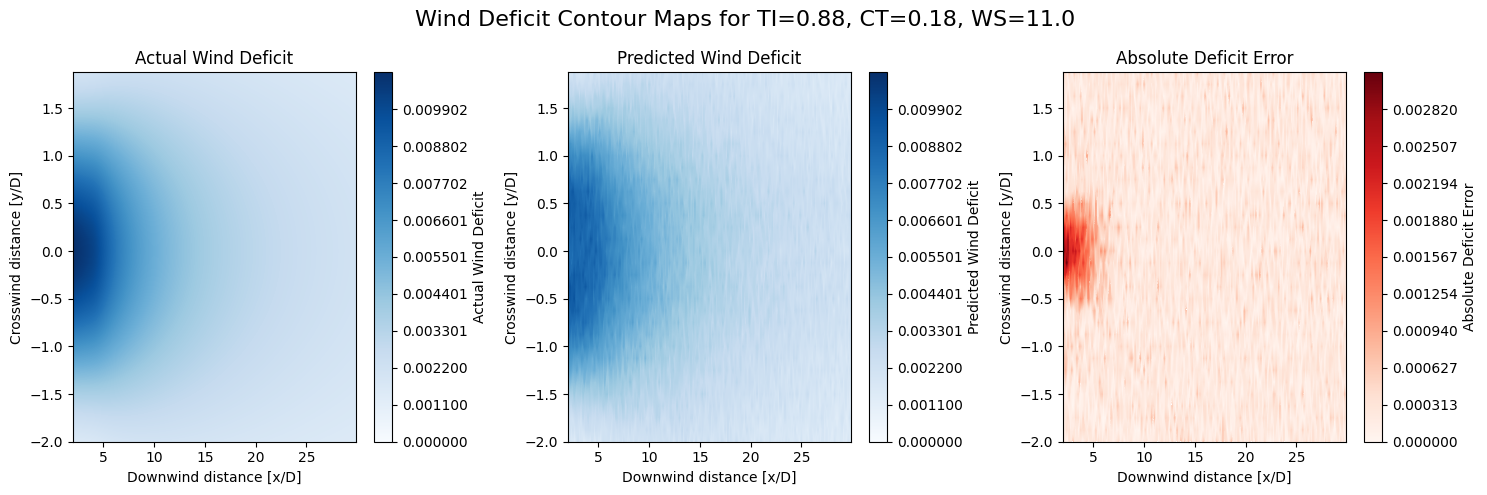

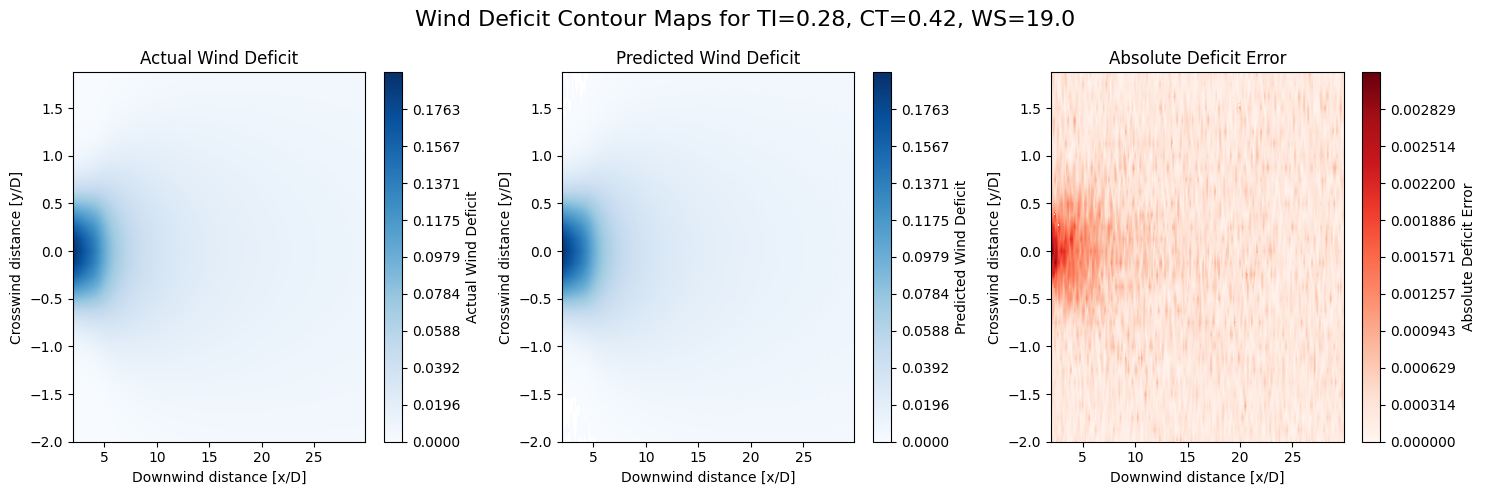

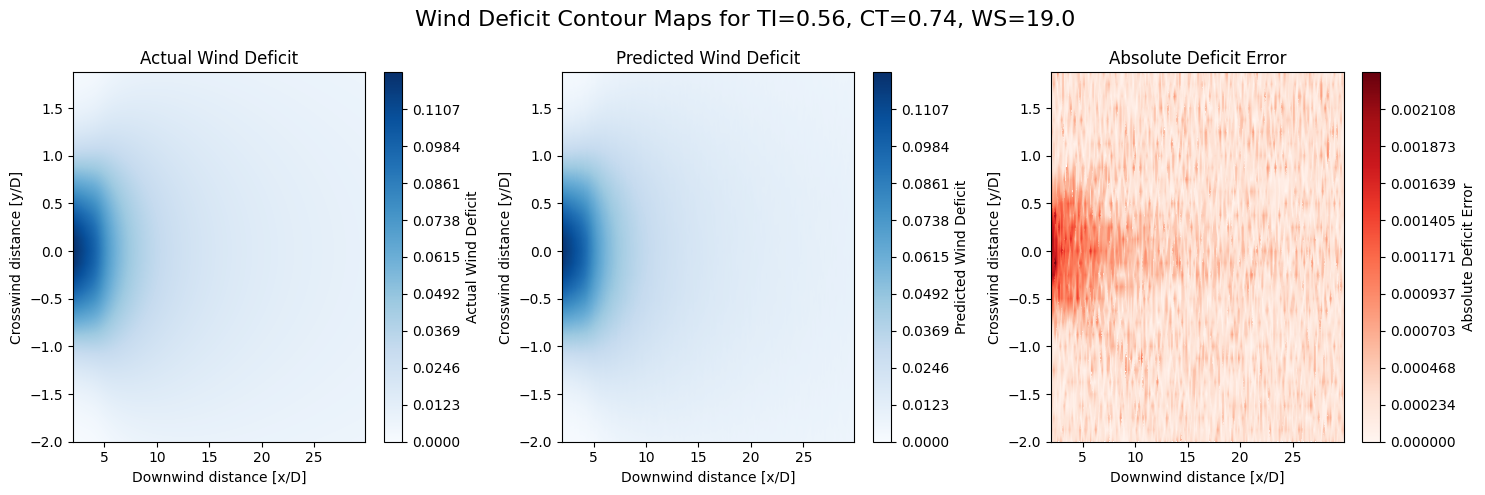

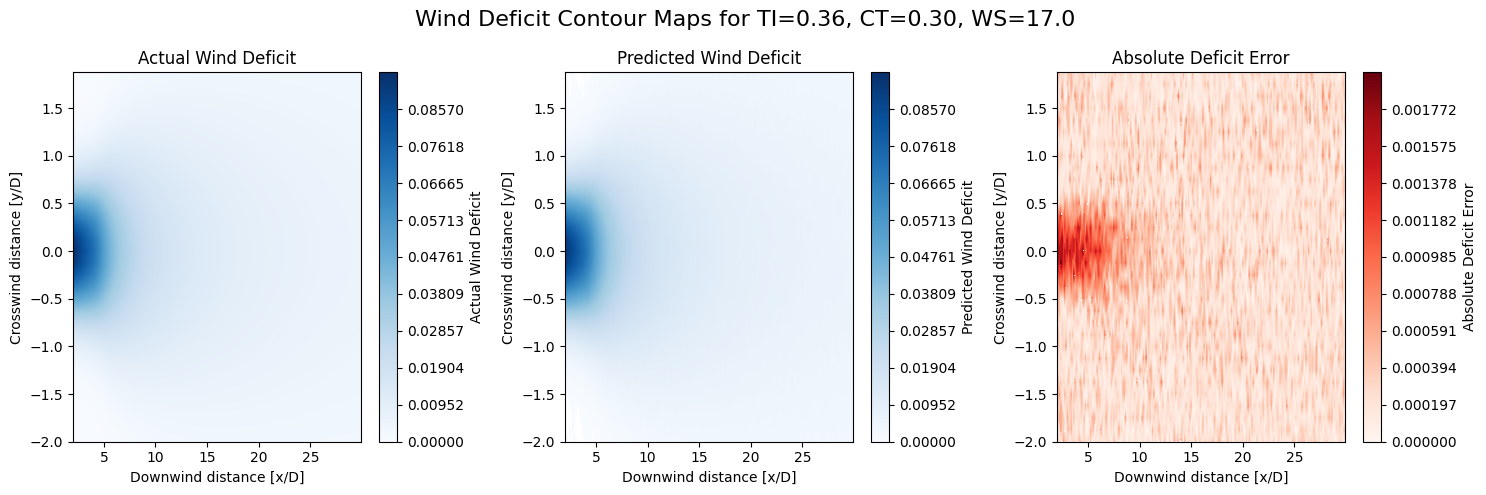

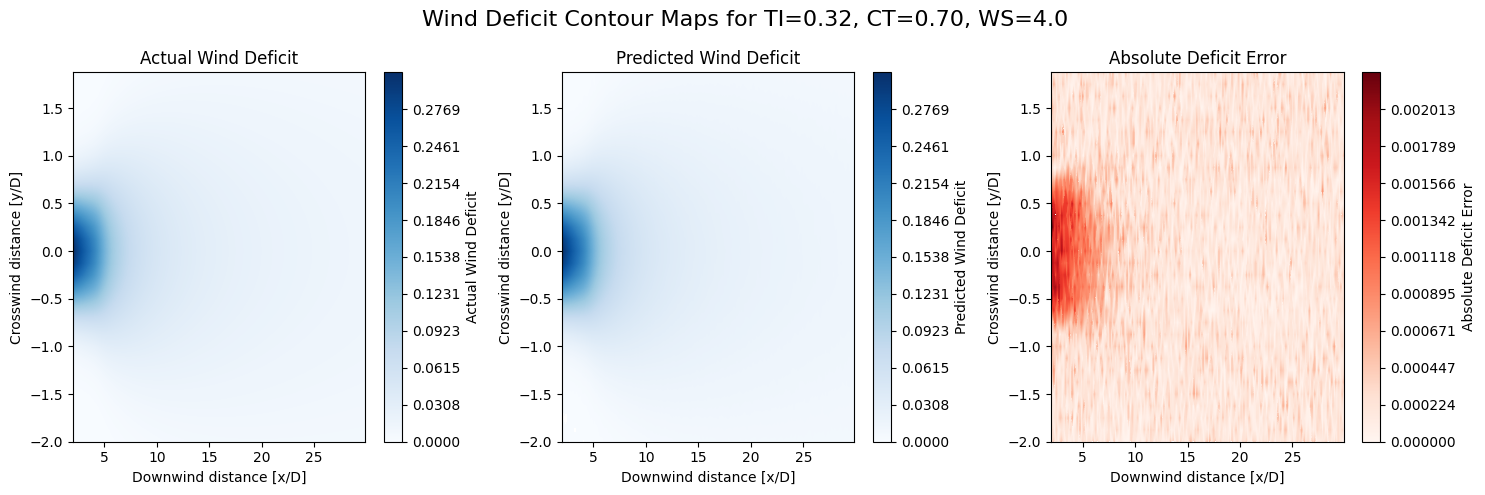

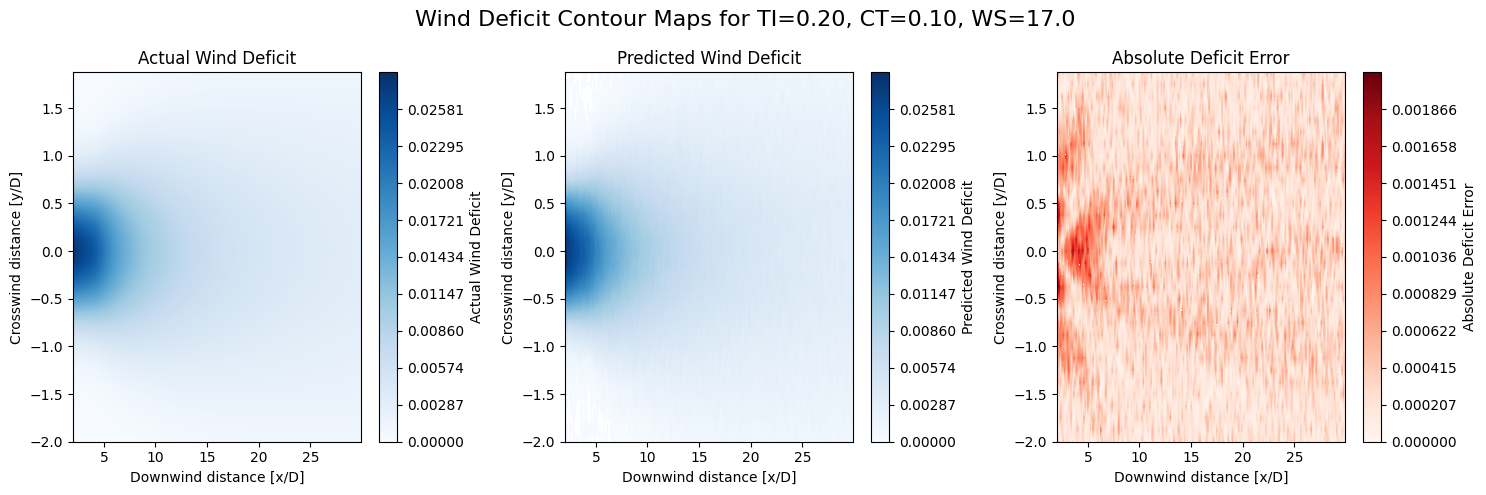

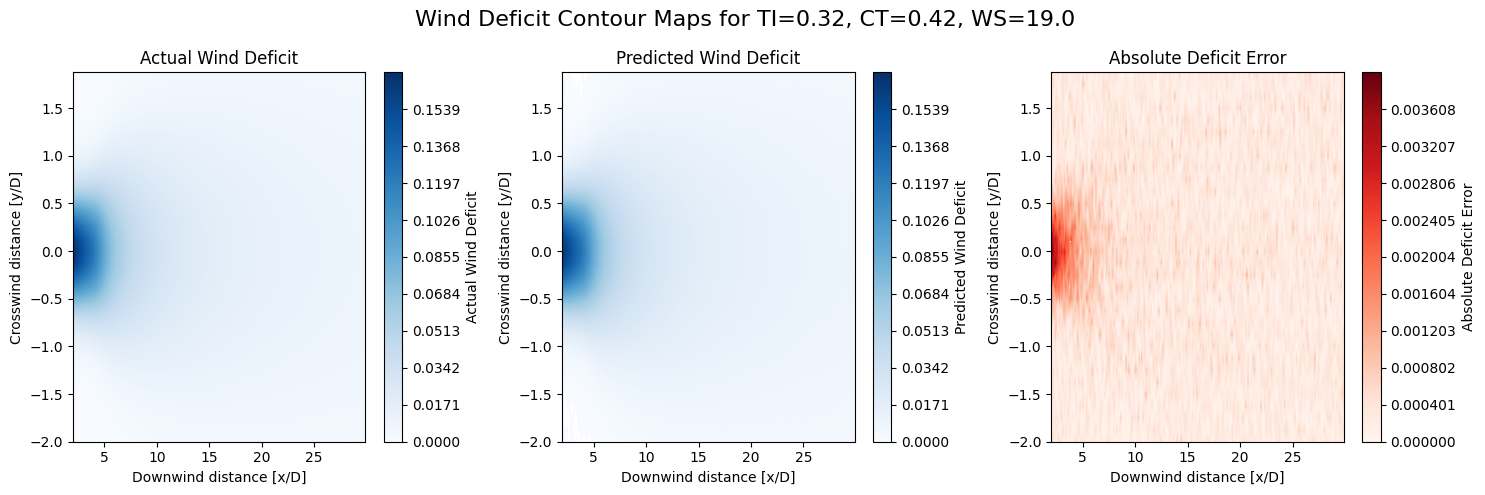

KeyboardInterrupt: 

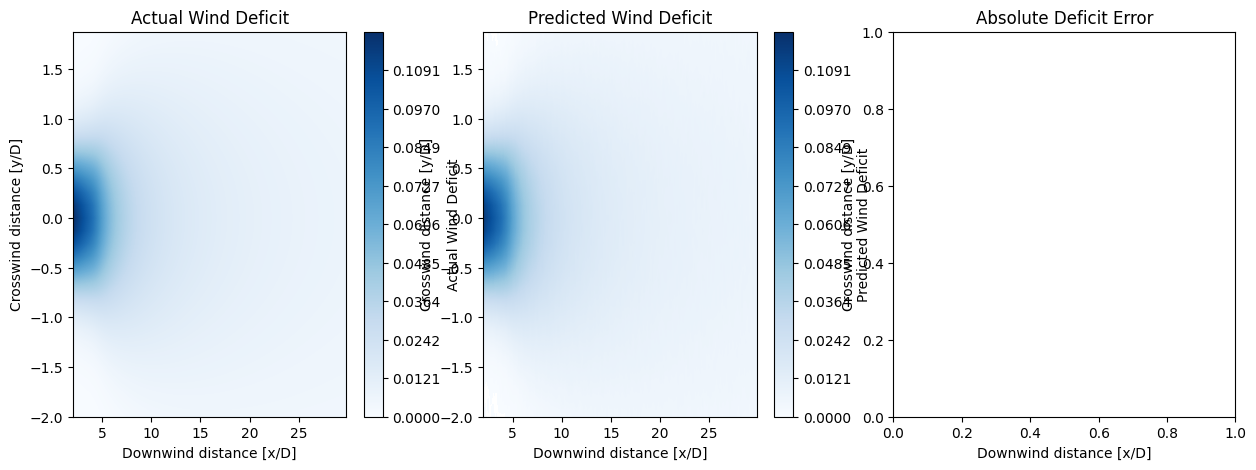

In [ ]:
test_dataset = test_dataloader.dataset
indices = list(range(len(test_dataset)))
random.shuffle(indices)
with torch.no_grad():
    for idx in indices:
        ti, ct, ws, wake_field, predicted_wake_field = test_dataset.get_parameters_for_plotting_multivariate(model, idx)
        
        plotting.plot_maps(test_dataset.X_grid, test_dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')